In [1]:
from multiprocessing import Pool, cpu_count
import gc; gc.enable()
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn import *
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

In [11]:
# reading train csv
wsdm_data = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\train_v2.csv")

# reading members csv
members_data = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\members_v3.csv")

# merging train dataset with members dataset
wsdm_members = pd.merge(wsdm_data, members_data, on='msno', how='left')
# getting the head (top 5 rows) of df
wsdm_members.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,20131223.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,20131227.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,20140109.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,20140125.0


In [12]:
### 4.1 Loading files to merge-

In [13]:
# train data
wsdm_data = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\train_v2.csv")
# members data
members_data = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\members_v3.csv")
# transactions data
transactions_data = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\transactions_v2.csv")
# user logs data
logs_data = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\user_logs_v2.csv")

In [14]:
### 4.2 Merging files together-
### 4.2.1 For train data-

In [15]:
# merging members data with train data
wsdm_members = pd.merge(wsdm_data, members_data, on='msno', how='left')
# merging transactions data with train members data
wsdm_mem_trans = pd.merge(wsdm_members, transactions_data, on='msno', how='left')
# merging user logs data with train members transaction data
wsdm_dataset = pd.merge(wsdm_mem_trans, logs_data, on='msno', how='left')
# getting head of train dataset
pd.set_option('display.max_columns', 100)
wsdm_dataset.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170305.0,7.0,0.0,3.0,5.0,71.0,68.0,17599.893
1,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170301.0,138.0,19.0,7.0,1.0,21.0,158.0,8830.433
2,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170319.0,0.0,0.0,0.0,0.0,34.0,17.0,7883.313
3,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170316.0,15.0,0.0,0.0,1.0,38.0,17.0,9029.227
4,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,20131223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170310.0,0.0,0.0,0.0,0.0,8.0,8.0,1870.110


In [16]:
wsdm_dataset.shape

(16887877, 23)

In [17]:
# since registration_init_time contains a lot of nan values so impute median date
wsdm_dataset['registration_init_time'] = wsdm_dataset['registration_init_time'].fillna(20150204.0)
# getting registration_init_time array
reg_date = wsdm_dataset['registration_init_time'].values
reg_date

array([20131223., 20131223., 20131223., ..., 20110905., 20110905.,
       20150204.])

In [18]:
len(reg_date)

16887877

In [19]:
# storing these train registrationn dates to npz file
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\wsdm_registration_date", reg_date)

<h3> Vorverarbeitung
   

In [20]:
def preprocess(data):
    '''This preprocess function is used to perform basic preprocessing on top of train and test dataset
    These preprocessing consist outliers removal, nan imputation and replacing the values'''
    
    # imputing 0 in place of nan values in the city column
    data['city'] = data['city'].fillna(0)

    # removing outliers
    data['bd'] = data['bd'].apply(lambda x: x if (x < 72.0) and (x > 0.0) else np.nan)
    # imputing 28 as age instead of nan
    data['bd'] = data['bd'].fillna(28.0)

    # replacing male with 1 in gender
    data['gender'] = data['gender'].replace(to_replace='male', value=1)
    # replacing male with 2 in gender
    data['gender'] = data['gender'].replace(to_replace='female', value=2)
    # replacing nan with 0 in gender
    data['gender'] = data['gender'].fillna(0)

    # replace 0 instead of nan in registered_via
    data['registered_via'] = data['registered_via'].fillna(0)

    # filling median date in place of nan in the df
    data['registration_init_time'] = data['registration_init_time'].fillna(20150204.0)
    # converting float date to datetime
    data['registration_init_time'] = pd.to_datetime(data['registration_init_time'], format='%Y%m%d')

    # imputing 0 in place of nan value in payment_method_id
    data['payment_method_id'] = data['payment_method_id'].fillna(0)

    # removing outliers
    data['payment_plan_days'] = data['payment_plan_days'].apply(lambda x: x if (x <= 30.0) else np.nan)
    # imputing 30 in place of nan in payment_plan_days
    data['payment_plan_days'] = data['payment_plan_days'].fillna(30.0)

    # removing outliers
    data['plan_list_price'] = data['plan_list_price'].apply(lambda x: x if (x <= 180.0) else np.nan)
    # imputing 149 in place of nan in plan_list_price
    data['plan_list_price'] = data['plan_list_price'].fillna(149.0)

    # removing outliers
    data['actual_amount_paid'] = data['actual_amount_paid'].apply(lambda x: x if (x <= 180.0) else np.nan)
    # imputing 149 in place of nan in actual_amount_paid
    data['actual_amount_paid'] = data['actual_amount_paid'].fillna(149.0)

    # imputing 2 in place of nan values in is_auto_renew
    data['is_auto_renew'] = data['is_auto_renew'].fillna(2)

    # filling median date in place of nan in the df
    data['transaction_date'] = data['transaction_date'].fillna(20170316.0)
    # converting float date to datetime
    data['transaction_date'] = pd.to_datetime(data['transaction_date'], format='%Y%m%d')

    # filling median date in place of nan in the df
    data['membership_expire_date'] = data['membership_expire_date'].fillna(20170419.0)
    # converting float date to datetime
    data['membership_expire_date'] = pd.to_datetime(data['membership_expire_date'], format='%Y%m%d')

    # imputing 2 in place of nan values in is_cancel
    data['is_cancel'] = data['is_cancel'].fillna(2)

    # filling median date in place of nan in the df
    data['date'] = data['date'].fillna(20170316.0)
    # converting float date to datetime
    data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

    # removing outliers
    data['num_25'] = data['num_25'].apply(lambda x: x if (x <= 15.0) else np.nan)
    # now I can impute 2 instead of nan in num_25
    data['num_25'] = data['num_25'].fillna(2.0)

    # removing outliers
    data['num_50'] = data['num_50'].apply(lambda x: x if (x <= 4.0) else np.nan)
    # now I can impute 0 instead of nan in num_50
    data['num_50'] = data['num_50'].fillna(0)

    # removing outliers
    data['num_75'] = data['num_75'].apply(lambda x: x if (x <= 3.0) else np.nan)
    # now I can impute 0 instead of nan in num_75
    data['num_75'] = data['num_75'].fillna(0)

    # removing outliers
    data['num_985'] = data['num_985'].apply(lambda x: x if (x <= 3.0) else np.nan)
    # now I can impute 0 instead of nan in num_985
    data['num_985'] = data['num_985'].fillna(0)

    # removing outliers
    data['num_100'] = data['num_100'].apply(lambda x: x if (x <= 74.0) else np.nan)
    # now I can impute 14 instead of nan in num_100
    data['num_100'] = data['num_100'].fillna(14.0)

    # removing outliers
    data['num_unq'] = data['num_unq'].apply(lambda x: x if (x <= 68.0) else np.nan)
    # now I can impute 16 instead of nan in num_unq
    data['num_unq'] = data['num_unq'].fillna(16.0)

    # removing outliers
    data['total_secs'] = data['total_secs'].apply(lambda x: x if (x <= 19167.549700000025) else np.nan)
    # now I can impute 3880.765 instead of nan in total_secs
    data['total_secs'] = data['total_secs'].fillna(3880.765)

In [21]:
# Checking null values for train data
# getting features wise null values (number)
wsdm_dataset.isnull().sum()

msno                            0
is_churn                        0
city                       117166
bd                         117166
gender                    7860346
registered_via             117166
registration_init_time          0
payment_method_id          340641
payment_plan_days          340641
plan_list_price            340641
actual_amount_paid         340641
is_auto_renew              340641
transaction_date           340641
membership_expire_date     340641
is_cancel                  340641
date                       249615
num_25                     249615
num_50                     249615
num_75                     249615
num_985                    249615
num_100                    249615
num_unq                    249615
total_secs                 249615
dtype: int64

In [22]:
# performing preprocessing on top of entire train data
preprocess(wsdm_dataset)

In [23]:
# again just to cross check if there is any null or not
wsdm_dataset.isnull().values.any()

False

In [24]:
# checking for any duplicate row
wsdm_dataset.duplicated().any()

False

In [25]:
# saving train file to disk
wsdm_dataset.to_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\train.csv", index=False)

<h2>Feature Engineering

In [26]:
# loading the files

wsdm_dataset = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\train.csv")

In [27]:
# getting head of wsdm file
pd.set_option('display.max_columns', 100)
wsdm_dataset.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,1.0,3.0,2013-12-23,0.0,30.0,149.0,149.0,2.0,2017-03-16,2017-04-19,2.0,2017-03-05,7.0,0.0,3.0,0.0,71.0,68.0,17599.893
1,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,1.0,3.0,2013-12-23,0.0,30.0,149.0,149.0,2.0,2017-03-16,2017-04-19,2.0,2017-03-01,2.0,0.0,0.0,1.0,21.0,16.0,8830.433
2,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,1.0,3.0,2013-12-23,0.0,30.0,149.0,149.0,2.0,2017-03-16,2017-04-19,2.0,2017-03-19,0.0,0.0,0.0,0.0,34.0,17.0,7883.313
3,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,1.0,3.0,2013-12-23,0.0,30.0,149.0,149.0,2.0,2017-03-16,2017-04-19,2.0,2017-03-16,15.0,0.0,0.0,1.0,38.0,17.0,9029.227
4,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,1.0,3.0,2013-12-23,0.0,30.0,149.0,149.0,2.0,2017-03-16,2017-04-19,2.0,2017-03-10,0.0,0.0,0.0,0.0,8.0,8.0,1870.110


In [23]:
%%time
# Feature - 4 to 12 (sum based features)
# Feature - 13 to 19 (mean based features)
# Feature - 20 to 27 (standard deviation based features)
# Feature - 28 (nunique based feature)
# Feature - 29 and 30 (min and max based features)
# Feature - 31 to 33 (mean based features for transaction)
# Feature - 34 (transaction count)
# Feature - 35 (transaction date max)
# Feature - 36 (membership expiry date max)
# Feature - 37 (membership expiry date count)

def std(x):
    '''finding standard deviation using numpy,
    to avoid getting nan values'''
    return np.std(x)

# grouping them together for train data
temp_df_train = wsdm_dataset.groupby('msno').agg(num_25_sum=('num_25', 'sum'),
                                num_50_sum=('num_50', 'sum'),
                                num_75_sum=('num_75', 'sum'),
                                num_985_sum=('num_985', 'sum'),
                                num_100_sum=('num_100', 'sum'),
                                num_unq_sum=('num_unq', 'sum'),
                                total_secs_sum=('total_secs', 'sum'),
                                num_25_mean=('num_25', 'mean'),
                                num_50_mean=('num_50', 'mean'),
                                num_75_mean=('num_75', 'mean'),
                                num_985_mean=('num_985', 'mean'),
                                num_100_mean=('num_100', 'mean'),
                                num_unq_mean=('num_unq', 'mean'),
                                total_secs_mean=('total_secs', 'mean'),
                                num_25_std=('num_25', std),
                                num_50_std=('num_50', std),
                                num_75_std=('num_75', std),
                                num_985_std=('num_985', std),
                                num_100_std=('num_100', std),
                                num_unq_std=('num_unq', std),
                                total_secs_std=('total_secs', std),
                                active_days=('date', 'nunique'),
                                date_min=('date', 'min'),
                                date_max=('date', 'max'),
                                payment_plan_days_mean=('payment_plan_days', 'mean'),
                                plan_list_price_mean=('plan_list_price', 'mean'),
                                actual_amount_paid_mean=('actual_amount_paid', 'mean'),
                                transaction_date_count=('transaction_date', 'nunique'),
                                transaction_date_max=('transaction_date', 'max'),
                                membership_expire_date_max=('membership_expire_date', 'max'),
                                membership_expire_count=('membership_expire_date', 'nunique'))
# merging them with the wsdm dataset
wsdm_dataset = pd.merge(wsdm_dataset, temp_df_train, on='msno', how='left')

Wall time: 5min 11s


In [25]:
# all features in train data
wsdm_dataset.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel', 'date',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'day_of_the_week', 'is_weekend', 'is_weekday',
       'num_25_sum', 'num_50_sum', 'num_75_sum', 'num_985_sum', 'num_100_sum',
       'num_unq_sum', 'total_secs_sum', 'is_weekend_sum', 'is_weekday_sum',
       'num_25_mean', 'num_50_mean', 'num_75_mean', 'num_985_mean',
       'num_100_mean', 'num_unq_mean', 'total_secs_mean', 'num_25_std',
       'num_50_std', 'num_75_std', 'num_985_std', 'num_100_std', 'num_unq_std',
       'total_secs_std', 'active_days', 'date_min', 'date_max',
       'payment_plan_days_mean', 'plan_list_price_mean',
       'actual_amount_paid_mean', 'transaction_date_count',
       'transaction_dat

In [26]:
# reference: https://medium.com/@vincentteyssier/optimizing-the-size-of-a-pandas-dataframe-for-low-memory-environment-5f07db3d72e
# reference: https://numpy.org/doc/stable/reference/generated/numpy.iinfo.html
# reference: https://numpy.org/doc/stable/reference/generated/numpy.finfo.html

def datatype_changer(dataset):
    # iterating through all the columns in the dataframe
    for col in dataset.columns:
        # getting column's datatype
        col_type = dataset[col].dtype
        
        # checking if datatype of column is 'object' or not
        # if column type is not object
        if (col_type == int) or (col_type == float):
            # getting minimum value of a column
            min_val = dataset[col].min()
            # getting maximum value of a column
            max_val = dataset[col].max()
            # checking whether the datatype contain first 3 characters as int or not, if int
            if str(col_type)[:3] == 'int':
                # cheking the minimal and maximal value for int8, int16, int32 and int64 in numpy
                if min_val > np.iinfo(np.int8).min and max_val < np.iinfo(np.int8).max:
                    dataset[col] = dataset[col].astype(np.int8)
                elif min_val > np.iinfo(np.int16).min and max_val < np.iinfo(np.int16).max:
                    dataset[col] = dataset[col].astype(np.int16)
                elif min_val > np.iinfo(np.int32).min and max_val < np.iinfo(np.int32).max:
                    dataset[col] = dataset[col].astype(np.int32)
                else:
                    dataset[col] = dataset[col].astype(np.int64)
            else:
                # if it is non int, which is ultimately float
                # cheking the minimal and maximal value for float16, float32 and float64 in numpy
                if min_val > np.finfo(np.float16).min and max_val < np.finfo(np.float16).max:
                    dataset[col] = dataset[col].astype(np.float16)
                elif min_val > np.finfo(np.float32).min and max_val < np.finfo(np.float32).max:
                    dataset[col] = dataset[col].astype(np.float32)
                else:
                    dataset[col] = dataset[col].astype(np.float64)
        else:
            # keeping rest of them to category datatype instead of object
            dataset[col] = dataset[col].astype('category')
            
    # returning head of the dataframe
    return dataset

In [27]:
wsdm_dataset = datatype_changer(wsdm_dataset)

In [28]:
# saving train file

wsdm_dataset.to_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\wsdm_FA.csv", index=False)

<h1>3. Prepare Data for Modelling

In [33]:
# loading train dataset
wsdm_dataset = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\wsdm_FA.csv")


In [34]:
# removing Rawdata Features
wsdm_dataset = wsdm_dataset.drop(['registration_init_time',
                              'transaction_date', 
                              'membership_expire_date', 
                              'date', 
                              'num_25',
                              'num_50',
                              'num_75',
                              'num_985',
                              'num_100',
                              'num_unq',
                              'total_secs',
                              'date_min', 
                              'date_max', 
                              'transaction_date_max', 
                              'membership_expire_date_max'], axis=1, inplace=False)

In [35]:
wsdm_dataset.head()

,msno,is_churn,city,bd,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean,num_25_std,num_50_std,num_75_std,num_985_std,num_100_std,num_unq_std,total_secs_std,active_days,payment_plan_days_mean,plan_list_price_mean,actual_amount_paid_mean,transaction_date_count,membership_expire_count
0,4TdIRNTyH46HoEHXpK1AQ055hhn28a1MooobsRtep9M=,0,1.0,28.0,0.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,50.0,7.0,8.0,11.0,163.0,114.0,39780.855,3.1250,0.4375,0.5000,0.6875,10.19,7.125,2486.0,3.0800,0.496,0.8660,0.7680,6.156,3.790,1354.0,16,30.0,149.0,149.0,1,1
1,KYVUFFy0q5xp9goCWgmg26yxRxrOwupdaUXUyF/4S0c=,0,4.0,30.0,1.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,4.0,0.0,4.0,1.0,82.0,55.0,19464.848,0.4443,0.0000,0.4443,0.1111,9.11,6.110,2162.0,0.4968,0.000,0.6850,0.3142,7.310,3.479,1755.0,9,30.0,149.0,149.0,1,1
2,1tncHVDk7eUP5YhFwse0YqG3C1/5jMlpsdhMl6aD5KU=,0,5.0,31.0,1.0,9.0,40.0,30.0,149.0,149.0,1.0,0.0,33.0,10.0,8.0,8.0,440.0,510.0,109529.836,1.9410,0.5884,0.4707,0.4707,25.88,30.000,6444.0,2.3380,0.691,0.8480,0.7760,17.380,19.030,4252.0,17,30.0,149.0,149.0,1,1
3,L8bqt1mnZVggDePVYOtNswDU6hKumsVeOvcJfQs9w3w=,0,1.0,28.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,84.0,21.0,12.0,12.0,422.0,453.0,114020.980,3.6520,0.9130,0.5220,0.5220,18.34,19.700,4956.0,3.4080,1.018,0.9263,0.8784,9.010,11.160,2268.0,23,30.0,99.0,99.0,1,1
4,P65TtYd9CVk47JWAaffMSfZP17FuWxie18q4fh8dkGg=,0,3.0,22.0,1.0,4.0,38.0,30.0,149.0,149.0,0.0,0.0,115.0,21.0,17.0,23.0,340.0,530.0,92981.750,6.7660,1.2350,1.0000,1.3530,20.00,31.170,5468.0,3.8440,1.113,0.9077,1.1860,9.080,12.230,2360.0,17,30.0,149.0,149.0,1,1


In [36]:
# adding registration init time feature to train dataset
# load the registration array
reg_date = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\wsdm_registration_date.npz")
# display the array
reg_date['arr_0']

array([20131223., 20131223., 20131223., ..., 20110905., 20110905.,
       20150204.])

In [37]:
# removing all duplicate rows for a particular id
wsdm_dataset = wsdm_dataset.drop_duplicates('msno', keep='first', inplace=False)


In [38]:
# saving new dataset
wsdm_dataset.to_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\prepared_train.csv", index=False)

In [39]:
# reading csv file for removing duplicates
wsdm_dataset = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\prepared_train.csv")
# getting all columns of train dataset
wsdm_dataset.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'is_cancel', 'num_25_sum',
       'num_50_sum', 'num_75_sum', 'num_985_sum', 'num_100_sum', 'num_unq_sum',
       'total_secs_sum', 'num_25_mean', 'num_50_mean', 'num_75_mean',
       'num_985_mean', 'num_100_mean', 'num_unq_mean', 'total_secs_mean',
       'num_25_std', 'num_50_std', 'num_75_std', 'num_985_std', 'num_100_std',
       'num_unq_std', 'total_secs_std', 'active_days',
       'payment_plan_days_mean', 'plan_list_price_mean',
       'actual_amount_paid_mean', 'transaction_date_count',
       'membership_expire_count'],
      dtype='object')

In [40]:
# removing all duplicate rows for a particular id
wsdm_dataset = wsdm_dataset.drop_duplicates('msno', keep='first', inplace=False)
# setting max_columns to 100, so it displays all the columns of train dataset
pd.set_option('display.max_columns', 100)
# displaying head (top 10) rows of train dataset
wsdm_dataset.head(100)

,msno,is_churn,city,bd,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean,num_25_std,num_50_std,num_75_std,num_985_std,num_100_std,num_unq_std,total_secs_std,active_days,payment_plan_days_mean,plan_list_price_mean,actual_amount_paid_mean,transaction_date_count,membership_expire_count
0,4TdIRNTyH46HoEHXpK1AQ055hhn28a1MooobsRtep9M=,0,1.0,28.0,0.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,50.0,7.0,8.0,11.0,163.0,114.0,39780.855,3.1250,0.4375,0.5000,0.6875,10.190,7.125,2486.0,3.0800,0.4960,0.8660,0.7680,6.156,3.790,1354.0,16,30.0,149.0,149.0,1,1
1,KYVUFFy0q5xp9goCWgmg26yxRxrOwupdaUXUyF/4S0c=,0,4.0,30.0,1.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,4.0,0.0,4.0,1.0,82.0,55.0,19464.848,0.4443,0.0000,0.4443,0.1111,9.110,6.110,2162.0,0.4968,0.0000,0.6850,0.3142,7.310,3.479,1755.0,9,30.0,149.0,149.0,1,1
2,1tncHVDk7eUP5YhFwse0YqG3C1/5jMlpsdhMl6aD5KU=,0,5.0,31.0,1.0,9.0,40.0,30.0,149.0,149.0,1.0,0.0,33.0,10.0,8.0,8.0,440.0,510.0,109529.836,1.9410,0.5884,0.4707,0.4707,25.880,30.000,6444.0,2.3380,0.6910,0.8480,0.7760,17.380,19.030,4252.0,17,30.0,149.0,149.0,1,1
3,L8bqt1mnZVggDePVYOtNswDU6hKumsVeOvcJfQs9w3w=,0,1.0,28.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,84.0,21.0,12.0,12.0,422.0,453.0,114020.980,3.6520,0.9130,0.5220,0.5220,18.340,19.700,4956.0,3.4080,1.0180,0.9263,0.8784,9.010,11.160,2268.0,23,30.0,99.0,99.0,1,1
4,P65TtYd9CVk47JWAaffMSfZP17FuWxie18q4fh8dkGg=,0,3.0,22.0,1.0,4.0,38.0,30.0,149.0,149.0,0.0,0.0,115.0,21.0,17.0,23.0,340.0,530.0,92981.750,6.7660,1.2350,1.0000,1.3530,20.000,31.170,5468.0,3.8440,1.1130,0.9077,1.1860,9.080,12.230,2360.0,17,30.0,149.0,149.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,oOQvmZSE5Xr48V7/wyoeW3B8QN+0TX9xZaS19m/O9C0=,0,1.0,28.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,38.0,13.0,13.0,14.0,235.0,161.0,94116.470,2.7150,0.9287,0.9287,1.0000,16.780,11.500,6724.0,3.6720,1.2230,1.0320,1.0000,14.375,12.100,6236.0,14,30.0,99.0,99.0,1,1
96,Pih04/9xCnao310ne2HuD83r8acxpwqg4IKrZCEpp98=,0,4.0,28.0,1.0,4.0,36.0,30.0,180.0,180.0,1.0,0.0,57.0,26.0,9.0,10.0,200.0,232.0,58069.305,3.3540,1.5290,0.5293,0.5884,11.766,13.650,3416.0,3.8030,1.0360,0.6960,0.6910,7.688,7.830,2152.0,17,30.0,180.0,180.0,1,1
97,6bB3bmiiiWkQ1CKVPbu8OjuUCFgUmb5rW8n7RIF7kak=,0,1.0,28.0,0.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,38.0,4.0,8.0,5.0,265.0,150.0,98688.125,2.0000,0.2106,0.4211,0.2632,13.945,7.895,5196.0,3.8650,0.5210,0.4937,0.5470,11.400,4.855,4396.0,19,30.0,149.0,149.0,1,1
98,Z4NNvNI+D4Kc4QC970tLcrRUc5M6oJrRMLSCwMqcDnE=,0,1.0,28.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,115.0,20.0,13.0,12.0,683.0,632.0,154462.170,5.4770,0.9520,0.6190,0.5713,32.530,30.100,7356.0,4.5300,1.1330,0.8438,0.7910,20.270,18.550,4416.0,21,30.0,99.0,99.0,1,1


In [41]:
# getting columns and converting them to list
cols = wsdm_dataset.columns.tolist()
# saving them for further use
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\columns.npz", cols)

In [42]:
# saving actual train dataset
wsdm_dataset.to_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\actual_train.csv", index=False)

<h2> 3.2 Train Test Split

In [43]:
# loading actual train data
wsdm_data = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\actual_train.csv")
# setting max_columns to 100, so it displays all the columns of train data
pd.set_option('display.max_columns', 100)
# displaying head (top 5) rows of train data
wsdm_data.head()

,msno,is_churn,city,bd,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean,num_25_std,num_50_std,num_75_std,num_985_std,num_100_std,num_unq_std,total_secs_std,active_days,payment_plan_days_mean,plan_list_price_mean,actual_amount_paid_mean,transaction_date_count,membership_expire_count
0,4TdIRNTyH46HoEHXpK1AQ055hhn28a1MooobsRtep9M=,0,1.0,28.0,0.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,50.0,7.0,8.0,11.0,163.0,114.0,39780.855,3.1250,0.4375,0.5000,0.6875,10.19,7.125,2486.0,3.0800,0.496,0.8660,0.7680,6.156,3.790,1354.0,16,30.0,149.0,149.0,1,1
1,KYVUFFy0q5xp9goCWgmg26yxRxrOwupdaUXUyF/4S0c=,0,4.0,30.0,1.0,7.0,41.0,30.0,149.0,149.0,1.0,0.0,4.0,0.0,4.0,1.0,82.0,55.0,19464.848,0.4443,0.0000,0.4443,0.1111,9.11,6.110,2162.0,0.4968,0.000,0.6850,0.3142,7.310,3.479,1755.0,9,30.0,149.0,149.0,1,1
2,1tncHVDk7eUP5YhFwse0YqG3C1/5jMlpsdhMl6aD5KU=,0,5.0,31.0,1.0,9.0,40.0,30.0,149.0,149.0,1.0,0.0,33.0,10.0,8.0,8.0,440.0,510.0,109529.836,1.9410,0.5884,0.4707,0.4707,25.88,30.000,6444.0,2.3380,0.691,0.8480,0.7760,17.380,19.030,4252.0,17,30.0,149.0,149.0,1,1
3,L8bqt1mnZVggDePVYOtNswDU6hKumsVeOvcJfQs9w3w=,0,1.0,28.0,0.0,7.0,41.0,30.0,99.0,99.0,1.0,0.0,84.0,21.0,12.0,12.0,422.0,453.0,114020.980,3.6520,0.9130,0.5220,0.5220,18.34,19.700,4956.0,3.4080,1.018,0.9263,0.8784,9.010,11.160,2268.0,23,30.0,99.0,99.0,1,1
4,P65TtYd9CVk47JWAaffMSfZP17FuWxie18q4fh8dkGg=,0,3.0,22.0,1.0,4.0,38.0,30.0,149.0,149.0,0.0,0.0,115.0,21.0,17.0,23.0,340.0,530.0,92981.750,6.7660,1.2350,1.0000,1.3530,20.00,31.170,5468.0,3.8440,1.113,0.9077,1.1860,9.080,12.230,2360.0,17,30.0,149.0,149.0,1,1


In [44]:
## Sample 50% of Data due to memory restrictions
wsdm_data = wsdm_data.sample(frac=.5)

In [45]:
# replacing all nan and infinity to 0
wsdm_data = wsdm_data.replace(np.nan, 0, inplace=False)
wsdm_data = wsdm_data.replace(np.inf, 0, inplace=False)

In [46]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('msno') and str(feature_name)!=str('is_churn')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

wsdm_dataset = normalize(wsdm_data)

In [62]:
# getting labels for y
labels = wsdm_dataset['is_churn'].values
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [63]:
# getting labels for X
data = wsdm_dataset.drop(['msno', 'is_churn'], axis=1, inplace=False)
data

,city,bd,gender,registered_via,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean,num_25_std,num_50_std,num_75_std,num_985_std,num_100_std,num_unq_std,total_secs_std,active_days,payment_plan_days_mean,plan_list_price_mean,actual_amount_paid_mean,transaction_date_count,membership_expire_count
145065,0.681818,0.442857,1.0,0.692308,0.951220,1.0,0.827778,0.827778,0.5,0.0,0.008929,0.015855,0.014477,0.004870,0.017519,0.002220,0.017701,0.091133,0.142825,0.183667,0.081633,0.310000,0.036239,0.305229,0.287200,0.4405,0.539733,0.286667,0.212514,0.098716,0.207996,0.933333,1.0,0.827778,0.827778,0.021739,0.004831
130110,0.045455,0.385714,0.0,0.538462,1.000000,1.0,0.827778,0.827778,0.5,0.0,0.006663,0.012458,0.005362,0.005276,0.008822,0.005144,0.007635,0.238133,0.392750,0.238133,0.309567,0.546486,0.398806,0.460773,0.382800,0.5890,0.530267,0.733333,0.572973,0.408955,0.538380,0.433333,1.0,0.827778,0.827778,0.000000,0.000000
702824,0.227273,0.542857,1.0,0.538462,1.000000,1.0,0.716667,0.716667,0.5,0.0,0.002532,0.005663,0.001609,0.000812,0.003117,0.002672,0.003455,0.126667,0.250000,0.100000,0.066667,0.270270,0.286567,0.291840,0.269467,0.6325,0.426667,0.266667,0.475135,0.487761,0.518977,0.300000,1.0,0.716667,0.716667,0.000000,0.000000
15565,0.590909,0.557143,0.5,0.538462,1.000000,1.0,0.550000,0.550000,0.5,0.0,0.000933,0.000566,0.000536,0.002029,0.006110,0.000306,0.006487,0.038900,0.020825,0.027767,0.138900,0.441351,0.014925,0.457112,0.258000,0.1382,0.184267,0.328667,0.296216,0.043940,0.301279,0.366667,1.0,0.550000,0.550000,0.000000,0.000000
284043,0.590909,0.371429,0.5,0.692308,0.975610,1.0,0.827778,0.827778,0.5,0.0,0.012393,0.012458,0.010724,0.003653,0.006297,0.005211,0.007206,0.413333,0.366750,0.444333,0.200000,0.364054,0.376119,0.405857,0.594667,0.6290,0.831333,0.722000,0.525676,0.523881,0.587420,0.466667,1.0,0.827778,0.827778,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814748,0.227273,0.414286,1.0,0.692308,0.000000,1.0,0.827778,0.827778,1.0,1.0,0.000000,0.000000,0.000536,0.000000,0.000203,0.000173,0.000223,0.000000,0.000000,0.166667,0.000000,0.087838,0.089552,0.094298,0.000000,0.0000,0.333333,0.000000,0.148649,0.179104,0.160341,0.033333,1.0,0.827778,0.827778,0.000000,0.000000
332824,0.045455,0.385714,0.0,0.692308,0.487805,1.0,0.827778,0.827778,0.0,0.0,0.005997,0.004530,0.002145,0.002841,0.005221,0.004599,0.005266,0.142867,0.095225,0.063467,0.111100,0.215541,0.231791,0.211923,0.311467,0.2875,0.261733,0.475333,0.295676,0.300597,0.294030,0.666667,1.0,0.827778,0.827778,0.000000,0.000000
711424,0.045455,0.385714,0.0,0.692308,0.731707,1.0,0.555556,0.555556,0.5,0.0,0.001999,0.001133,0.001072,0.000406,0.000125,0.000253,0.000149,0.500000,0.250000,0.333333,0.166667,0.054054,0.134328,0.063021,0.733333,0.5000,0.666667,0.333333,0.081081,0.208955,0.076279,0.033333,1.0,0.555556,0.555556,0.000000,0.000000
239804,0.045455,0.385714,0.0,0.692308,0.926829,1.0,0.827778,0.827778,0.0,0.0,0.018390,0.022650,0.012869,0.012987,0.008011,0.009611,0.009983,0.354000,0.384500,0.307667,0.410000,0.267162,0.400597,0.324476,0.540667,0.6825,0.714000,0.723333,0.328919,0.465373,0.363326,0.833333,1.0,0.827778,0.827778,0.000000,0.000000


In [64]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(314428, 37) (314428,)
(134756, 37) (134756,)


In [65]:
# converting X_train to numpy array
wsdm_arr = X_train.values
wsdm_arr

array([[0.04545455, 0.38571429, 0.        , ..., 0.55      , 0.        ,
        0.        ],
       [0.59090909, 0.42857143, 1.        , ..., 0.82777778, 0.02173913,
        0.00483092],
       [0.59090909, 0.27142857, 0.5       , ..., 0.82777778, 0.        ,
        0.        ],
       ...,
       [0.04545455, 0.38571429, 0.        , ..., 0.55      , 0.        ,
        0.        ],
       [0.40909091, 0.45714286, 1.        , ..., 0.82777778, 0.        ,
        0.        ],
       [0.04545455, 0.38571429, 0.        , ..., 0.82777778, 0.        ,
        0.        ]])

In [66]:
# checking shape of train array
wsdm_arr.shape

(314428, 37)

In [67]:
# saving it for further use
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\actual_train.npz", wsdm_arr)

In [68]:
# displaying y_train
wsdm_labels_arr = y_train
wsdm_labels_arr

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [69]:
# checking shape of train labels
wsdm_labels_arr.shape

(314428,)

In [70]:
# saving it for further use
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\actual_wsdm_labels.npz", wsdm_labels_arr)

In [71]:
# converting X_test to numpy array
cv_arr = X_test.values
cv_arr

array([[0.04545455, 0.38571429, 0.        , ..., 0.55      , 0.        ,
        0.        ],
       [0.27272727, 0.74285714, 1.        , ..., 0.82777778, 0.02173913,
        0.00483092],
       [0.04545455, 0.31428571, 0.5       , ..., 1.        , 0.02173913,
        0.00483092],
       ...,
       [0.18181818, 0.41428571, 1.        , ..., 0.55      , 0.        ,
        0.        ],
       [0.04545455, 0.38571429, 0.        , ..., 0.82777778, 0.        ,
        0.        ],
       [0.40909091, 0.54285714, 1.        , ..., 0.82777778, 0.        ,
        0.        ]])

In [72]:
# checking shape of cv array
cv_arr.shape

(134756, 37)

In [73]:
# saving it for further use
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\actual_cv.npz", cv_arr)

In [74]:
# displaying y_test
cv_labels_arr = y_test
cv_labels_arr

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [75]:
# checking shape of cv labels array
cv_labels_arr.shape

(134756,)

In [76]:
# saving it for further use
np.savez_compressed(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\actual_cv_labels.npz", cv_labels_arr)

<h1> 5. Modelling

In [6]:
# loading library
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


In [7]:
# reference: https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/
X_train = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\actual_train.npz")
y_train = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\actual_wsdm_labels.npz")
X_test = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\actual_cv.npz")
y_test = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\actual_cv_labels.npz")


In [8]:
X_train = X_train['arr_0']
X_test = X_test['arr_0']
y_train = y_train['arr_0']
y_test = y_test['arr_0']

# getting shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(314428, 37) (314428,)
(134756, 37) (134756,)


In [9]:
# loading columns
cols = np.load(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\columns.npz")
# converting numpy array to python list
cols = cols['arr_0'].tolist()
# removing first two cols 'msno' and 'is_churn'
cols = cols[2:]

<h3> Logistic Regression

In [81]:
%%time

# fitting logistic regression model with best parameter values
lr_model = LogisticRegression(penalty='l2', tol=0.0001, C=10, solver='newton-cg', class_weight='balanced', n_jobs=-1)
lr_model.fit(X_train, y_train)

Wall time: 43.7 s


LogisticRegression(C=10, class_weight='balanced', n_jobs=-1, solver='newton-cg')

In [82]:
# Reference: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.
# saving the trained logistic regression ML model
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_2\finalized_model_lr.sav"
joblib.dump(lr_model, filename)

['D:\\Work_Masterarbeit\\wsdm\\preprocessed_2\\finalized_model_lr.sav']

In [83]:
# loading the best model from disk
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_2\finalized_model_lr.sav"
loaded_model = joblib.load(filename)

<h3> Model Evaluation

In [85]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

lr_predict=lr_model.predict(X_test)
lr_predict


print('Accuracy:', accuracy_score(y_test, lr_predict))
print('F1 score weighted:', f1_score(y_test, lr_predict,average='weighted'))
print('F1 score macro:', f1_score(y_test, lr_predict, average='macro'))
print('Recall:', recall_score(y_test, lr_predict,average='weighted'))
print('Precision:', precision_score(y_test, lr_predict,average='weighted'))
print('\n clasification report:\n', classification_report(y_test, lr_predict))
print('\n confussion matrix:\n',confusion_matrix(y_test, lr_predict))

Accuracy: 0.9005981180800855
F1 score weighted: 0.9126550469597535
F1 score macro: 0.7787752595332607
Recall: 0.9005981180800855
Precision: 0.9377646831313515

 clasification report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94    122326
           1       0.48      0.86      0.61     12430

    accuracy                           0.90    134756
   macro avg       0.73      0.88      0.78    134756
weighted avg       0.94      0.90      0.91    134756


 confussion matrix:
 [[110680  11646]
 [  1749  10681]]


In [86]:
## Logloss
# predicting probabilities for X_cv
pred_test = loaded_model.predict_proba(X_test)
# getting probabilities corresponding to class label 1 only
pred_test = pred_test[:,1]
# calculating log loss
print('Test log-loss: ', log_loss(y_test, pred_test))

train log-loss:  0.3455977945059412
cv log-loss:  0.3491868626729595


## Feature Importance

Feature: 0, Score: 79.59419
Feature: 1, Score: 19.12693
Feature: 2, Score: 15.41556
Feature: 3, Score: 9.13291
Feature: 4, Score: 7.72892
Feature: 5, Score: 4.43398
Feature: 6, Score: 1.18490
Feature: 7, Score: 0.83092
Feature: 8, Score: 0.81583
Feature: 9, Score: 0.55603


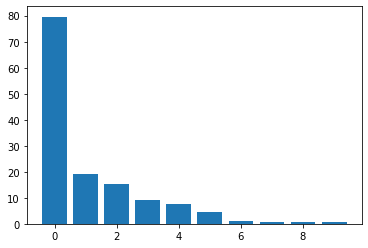

In [18]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

# getting important features
imp_features = loaded_model.coef_
# converting 2-d numpy array to 1-d
imp_features = imp_features.flatten()
# sorting in descending order
imp_features = sorted(imp_features, reverse=True)
# taking top 10 most important features only
imp_features = imp_features[:10]
# summarize feature importance
for i,v in enumerate(imp_features):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(imp_features))], imp_features)
pyplot.show()

<h2> Decision Tree

In [18]:
%%time

# training a decision tree classifier model with best parameters
dtc_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, min_samples_split=3, min_samples_leaf=1)
dtc_model.fit(X_train, y_train)

Wall time: 2.02 s


DecisionTreeClassifier(max_depth=5, min_samples_split=3)

In [19]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.
# saving the decision tree classifier model
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_2\finalized_model_dtc.sav"
joblib.dump(dtc_model, filename)

['D:\\Work_Masterarbeit\\wsdm\\preprocessed_2\\finalized_model_dtc.sav']

In [20]:
# loading the best decision tree classifier model from disk
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_2\finalized_model_dtc.sav"
loaded_model = joblib.load(filename)

In [21]:
## Logloss
# predicting probabilities for X_cv
pred_test = loaded_model.predict_proba(X_test)
# getting probabilities corresponding to class label 1 only
pred_test = pred_test[:,1]
# calculating log loss
print('Test log-loss: ', log_loss(y_test, pred_test))

Test log-loss:  0.1316510832445639


<h3> Model Evaluation

In [90]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

dtc_modelpred=dtc_model.predict(X_test)
dtc_modelpred


print('Accuracy:', accuracy_score(y_test, dtc_modelpred))
print('F1 score weighted:', f1_score(y_test, dtc_modelpred,average='weighted'))
print('F1 score macro:', f1_score(y_test, dtc_modelpred, average='macro'))
print('Recall:', recall_score(y_test, dtc_modelpred,average='weighted'))
print('Precision:', precision_score(y_test, dtc_modelpred,average='weighted'))
print('\n clasification report:\n', classification_report(y_test, dtc_modelpred))
print('\n confussion matrix:\n',confusion_matrix(y_test, dtc_modelpred))

Accuracy: 0.9554379767876755
F1 score weighted: 0.9525695347001834
F1 score macro: 0.8500556122133449
Recall: 0.9554379767876755
Precision: 0.9526906376154943

 clasification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98    122326
           1       0.84      0.63      0.72     12430

    accuracy                           0.96    134756
   macro avg       0.90      0.81      0.85    134756
weighted avg       0.95      0.96      0.95    134756


 confussion matrix:
 [[120861   1465]
 [  4540   7890]]


<h2> Random Forest

In [10]:
%%time

# training the random forest classifier for best hyper parameters
rf_model = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=15, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', bootstrap=True, n_jobs=-1)
rf_model.fit(X_train, y_train)

Wall time: 1min 47s


RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000, n_jobs=-1)

In [11]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

rf_modelpred=rf_model.predict(X_test)
rf_modelpred


print('Accuracy:', accuracy_score(y_test, rf_modelpred))
print('F1 score weighted:', f1_score(y_test, rf_modelpred,average='weighted'))
print('F1 score macro:', f1_score(y_test, rf_modelpred, average='macro'))
print('Recall:', recall_score(y_test, rf_modelpred,average='weighted'))
print('Precision:', precision_score(y_test, rf_modelpred,average='weighted'))
print('\n clasification report:\n', classification_report(y_test, rf_modelpred))
print('\n confussion matrix:\n',confusion_matrix(y_test, rf_modelpred))

Accuracy: 0.9609219626584345
F1 score weighted: 0.9592199033305188
F1 score macro: 0.8732596496997173
Recall: 0.9609219626584345
Precision: 0.9589715486984737

 clasification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    122326
           1       0.85      0.70      0.77     12430

    accuracy                           0.96    134756
   macro avg       0.91      0.84      0.87    134756
weighted avg       0.96      0.96      0.96    134756


 confussion matrix:
 [[120781   1545]
 [  3721   8709]]


In [14]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.
# saving the decision tree classifier model
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_2\finalized_model_rf.sav"
joblib.dump(rf_model, filename)

['D:\\Work_Masterarbeit\\wsdm\\preprocessed_2\\finalized_model_rf.sav']

In [15]:
# loading the best decision tree classifier model from disk
filename = r"D:\Work_Masterarbeit\wsdm\preprocessed_2\finalized_model_rf.sav"
loaded_model = joblib.load(filename)

In [16]:
## Logloss
# predicting probabilities for X_cv
pred_test = loaded_model.predict_proba(X_test)
# getting probabilities corresponding to class label 1 only
pred_test = pred_test[:,1]
# calculating log loss
print('Test log-loss: ', log_loss(y_test, pred_test))

Test log-loss:  0.11347459251572552


<h2> Neuronales Netz

In [9]:
# getting device information
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1657253831252358455]

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
init = tf.keras.initializers.HeUniform()
regular = tf.keras.regularizers.l2(l2=0.01)

# Input layer
input_layer = Input(shape=(40,))

# Dense hidden layer 1
layer1 = Dense(64, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(input_layer)

# Batch Normalization layer 1
b_norm1 = BatchNormalization()(layer1)

# Dropout layer 1
drop1 = Dropout(rate=0.5)(b_norm1)

# Dense hidden layer 2
layer2 = Dense(32, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(drop1)

# Batch Normalization layer 2
b_norm2 = BatchNormalization()(layer2)

# Dropout layer 2
drop2 = Dropout(rate=0.5)(b_norm2)

# Dense hidden layer 3
layer3 = Dense(16, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(drop2)

# Batch Normalization layer 3
b_norm3 = BatchNormalization()(layer3)

# Dropout layer 3
drop3 = Dropout(rate=0.5)(b_norm3)

# Output layer
output_layer = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(), kernel_regularizer=regular)(drop3)

# Creating a model
model = Model(inputs=input_layer, outputs=output_layer)

# summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0     

In [11]:
# Compile model
adam = tf.keras.optimizers.Adam()

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [12]:
filepath = r"D:\Work_Masterarbeit\wsdm\preprocessed_2\best_model.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

es = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1, restore_best_weights=True)

cb = [es, checkpoint]

In [13]:
# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test), verbose=1, callbacks=cb)

Epoch 1/10
2655/2655 [==============================] - 7s 2ms/step - loss: 0.4778 - accuracy: 0.9123 - val_loss: 0.1659 - val_accuracy: 0.9478

Epoch 00001: val_loss improved from inf to 0.16593, saving model to D:\Work_Masterarbeit\wsdm\preprocessed_2\best_model.h5
Epoch 2/10
2655/2655 [==============================] - 6s 2ms/step - loss: 0.1828 - accuracy: 0.9412 - val_loss: 0.1612 - val_accuracy: 0.9511

Epoch 00002: val_loss improved from 0.16593 to 0.16120, saving model to D:\Work_Masterarbeit\wsdm\preprocessed_2\best_model.h5
Epoch 3/10
2655/2655 [==============================] - 6s 2ms/step - loss: 0.1766 - accuracy: 0.9403 - val_loss: 0.2140 - val_accuracy: 0.9412

Epoch 00003: val_loss did not improve from 0.16120
Epoch 4/10
2655/2655 [==============================] - 6s 2ms/step - loss: 0.1727 - accuracy: 0.9411 - val_loss: 0.1794 - val_accuracy: 0.9437

Epoch 00004: val_loss did not improve from 0.16120
Epoch 5/10
2655/2655 [==============================] - 6s 2ms/step 

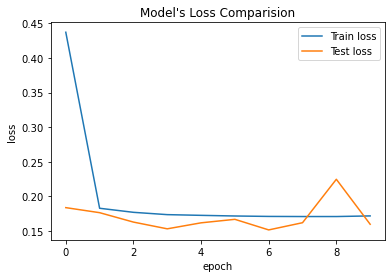

In [22]:
# loss comparison plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Loss Comparision")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.show()

In [16]:
# loading best model from disk
model = load_model(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\best_model.h5")

# predicting probabilities for test data
pred_test = model.predict(test_data)
# converting 2d array to 1d using flatten
pred_test = pred_test.flatten()
# getting probabilities
pred_test

array([0.01678967, 0.00569916, 0.00804362, ..., 0.00780249, 0.00766623,
       0.00691232], dtype=float32)

In [18]:
# loading sample submission file
submit = pd.read_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\sample_submission_v2.csv")
# dropping default class labels
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5 rows)
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [19]:
# multiplying 0.6 with class labels, and assigning them to new feature 'is_churn'
submit['is_churn'] = pred_test * 0.6
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.010074
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.003419
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.004826
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.007832
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.009119


In [20]:
# saving csv file to the disk
submit.to_csv(r"D:\Work_Masterarbeit\wsdm\preprocessed_2\submission_ffnn06.csv", index=False)

<h4> By using this model I got 0.12291 as public leaderboard test log-loss, and 0.12209 as private leaderboard test log-loss.

In [ ]:
+------------------------------------+--------------------------+---------------------------+
|             Model name             | Public leaderboard score | Private leaderboard score |
+------------------------------------+--------------------------+---------------------------+
|      Random Forest Classifier      |         0.15946          |           0.1591          |
|      Decision Tree Classifier      |         0.15749          |          0.15624          |
|        Logistic Regression         |         0.15197          |          0.15148          |
|              CatBoost              |         0.13111          |          0.13013          |
|              XGBoost               |         0.12702          |          0.12603          |
|              LightGBM              |         0.12697          |           0.126           |
| Averaged Model(xgboost + lightGBM) |          0.1266          |          0.12562          |
|      Neural Network Model - 1      |         0.12291          |          0.12209          |
|      Neural Network Model - 2      |         0.12136          |          0.12043          |
|   Averaged Model(NN1 + NN2 + NN3   |         0.11994          |          0.11898          |
|      Neural Network Model - 3      |          0.1198          |          0.11866          |
+------------------------------------+--------------------------+---------------------------+